Библиотеки, используемые в работе

In [51]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as functional
from torchvision import transforms

Загрузка необзодимого (исходного) набора данных и соответствующих меток классов

In [52]:
csv_path = "C:/Users/zhura/Desktop/paths.csv"
df = pd.read_csv(csv_path, delimiter=";", names=["Absolute path", "Relative path", "Label"])
images = df["Absolute path"].to_list()
random.shuffle(images)
img_label=[]
for i in range(len(images)):
    img_label.append(os.path.basename(os.path.dirname(images[i])))
print(img_label[:10])

['polar bear', 'brown bear', 'polar bear', 'polar bear', 'brown bear', 'polar bear', 'brown bear', 'polar bear', 'polar bear', 'brown bear']


Разделение в заданном соотношении 80:10:10 и проверка на сбаллансированность

In [53]:
train_list = images[0:int(len(images) * 0.8)]
test_list = images[int(len(images) * 0.8) : int(len(images) * 0.9)]
valid_list = images[int(len(images) * 0.9) : int(len(images))]

print(len(train_list), len(test_list), len(valid_list))

1600 200 200


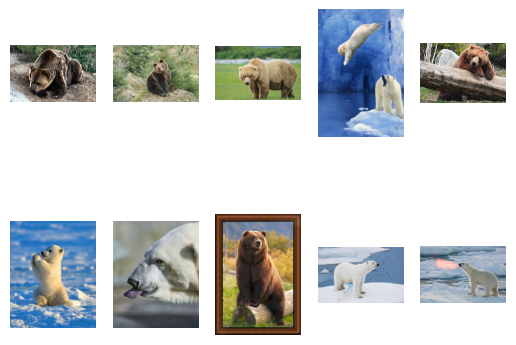

In [54]:
random_idx = np.random.randint(1,len(images),size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(images[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off')
    
plt.show()

Формирование модели сверточной нейронной сети для решения задач классификации

In [55]:
class dataset(torch.utils.data.Dataset):
    
    def __init__(self,dataset,transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.dataset)
        return self.filelength
    
    def __getitem__(self,index:int):
        img_label=[]
        for i in range(len(self.dataset)):
            img_label.append(os.path.basename(os.path.dirname(self.dataset[i])))
        img_path = self.dataset[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_label[index]
        if label == 'polar bear':
            label=0
        elif label == 'brown bear':
            label=1
        return img_transformed,label

In [56]:
fixed_transforms = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    )
train_data = dataset(train_list, transform=fixed_transforms)
test_data = dataset(test_list, transform=fixed_transforms)
val_data = dataset(valid_list, transform=fixed_transforms)
print(train_data.transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


In [57]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        output = self.layer1(x)
        output = self.layer2(output)
        output = self.layer3(output)
        output = output.view(output.size(0),-1)
        output = self.relu(self.fc1(output))
        output = self.fc2(output)
        return output

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
    
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [59]:
def draw_results(epochs, train_acc, train_loss, val_acc, val_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(range(epochs), train_acc, color="green", label="Training accuracy")
    ax2.plot(range(epochs), train_loss, color="green", label="Training loss")
    ax1.plot(range(epochs), val_acc, color="orange", label="Validation accuracy")
    ax2.plot(range(epochs), val_loss, color="orange", label="Validation loss")
    ax1.legend()
    ax2.legend()
    plt.show() 

Цикл обучения 

In [60]:
def train_loop(epochs, batch_size, lear):
    optimizer = optim.Adam(params = model.parameters(),lr=lear)
    criterion = nn.CrossEntropyLoss()
    epochs = epochs
    accuracy_values = []
    loss_values = []
    val_accuracy_values=[]
    val_loss_values=[]
    val_loader = torch.utils.data.DataLoader(dataset = val_data, 
                                            batch_size=batch_size, 
                                            shuffle=False)
    train_loader = torch.utils.data.DataLoader(dataset = train_data, 
                                            batch_size=batch_size, 
                                            shuffle=True )
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        
        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)
            
            output = model(data)
            loss = criterion(output, label)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc/len(train_loader)
            epoch_loss += loss/len(train_loader)
            
        print('Epoch : {}, training accuracy : {}, training loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
        accuracy_values.append(epoch_accuracy.item())
        loss_values.append(epoch_loss.item())

        with torch.no_grad():
            epoch_val_accuracy=0
            epoch_val_loss =0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)
                
                val_output = model(data)
                val_loss = criterion(val_output,label)
                
                
                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc/ len(val_loader)
                epoch_val_loss += val_loss/ len(val_loader)
                
            print('Epoch : {}, validation accuracy : {}, validation loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))
            val_accuracy_values.append(epoch_val_accuracy.item())
            val_loss_values.append(epoch_val_loss.item()) 
    draw_results(epochs,accuracy_values, loss_values, val_accuracy_values, val_loss_values)

In [61]:
train_loop(10, 100, 0.001)  

Epoch : 1, training accuracy : 0.8612499237060547, training loss : 0.37432461977005005
Epoch : 1, validation accuracy : 0.9350000023841858, validation loss : 0.19864797592163086
Epoch : 2, training accuracy : 0.9362499117851257, training loss : 0.17216156423091888
Epoch : 2, validation accuracy : 0.949999988079071, validation loss : 0.13350114226341248
Epoch : 3, training accuracy : 0.9418749213218689, training loss : 0.15594890713691711
Epoch : 3, validation accuracy : 0.9599999785423279, validation loss : 0.1206282377243042


KeyboardInterrupt: 

In [ ]:
train_loop(10, 200, 0.001)

In [ ]:
train_loop(10, 300, 0.001)

In [ ]:
train_loop(10, 100, 0.005)

In [ ]:
train_loop(10, 200, 0.005)

In [ ]:
train_loop(10, 300, 0.005)

In [ ]:
train_loop(10, 100, 0.007)

In [ ]:
train_loop(10, 200, 0.007)

In [ ]:
train_loop(10, 300, 0.007)